In [47]:
import torch
from torch.utils.data import DataLoader
from models.resnet_clothing_model import ClothingClassifier
from utils.loss import compute_loss
from utils.metrics import accuracy
from data.transformation import CustomResNetTransform
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np
from PIL import Image
import random
from torchvision import transforms
from torch.utils.data import Dataset
import os

In [48]:
class GarmentDatasetShowCase(Dataset):
    def __init__(self, df, transform=None):
        self.labels = df['category_label'].values.astype(np.int64)
        self.image_paths = df['image_name'].values
        self.n_samples = len(self.image_paths)
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        category_id = int(self.labels[index])
        imageOriginal = Image.open("dataset/" + image_path).convert('RGB')
        if self.transform:
            image_transformed = self.transform(imageOriginal)
        else:
            image_transformed = imageOriginal
        return imageOriginal, image_transformed, category_id

    def __len__(self):
        return self.n_samples

In [49]:
"""
DATA SET UP
"""
df = pd.read_csv('dataset/list_category_img.txt', delim_whitespace=True, skiprows=1)
selected_labels = [3, 6, 11, 16, 17, 18, 19, 26, 32, 33, 41]
selected_names = ["Blouse", "Cardigan", "Jacket", "Sweater", "Tank", "Tee", "Top", "Jeans", "Shorts", "Skirts", "Dress"]
df = df[df['category_label'].isin(selected_labels)]
df = df.reset_index(drop=True)


label_mapping = {original: new for new, original in enumerate(selected_labels)}
df['category_label'] = df['category_label'].map(label_mapping)

_, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=1331,
    stratify=df['category_label']
)

test_dataset = GarmentDatasetShowCase(test_df, transform=CustomResNetTransform())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

inference_label_mapping = {new: name for new, name in enumerate(selected_names)}


/var/folders/nj/y687jr_s3vdc8l49m6_mn7sm0000gn/T/ipykernel_55717/3808596283.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('dataset/list_category_img.txt', delim_whitespace=True, skiprows=1)


Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Class: Skirts
True Class: Skirts


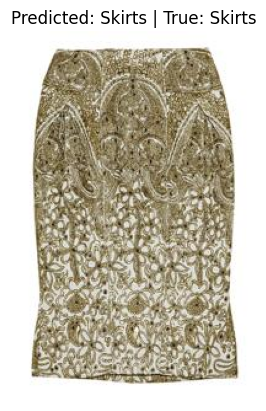

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

"""
MODEL SETUP
"""
# Make sure ClothingClassifier is imported or defined in your codebase
NUM_CLASSES = 11
FROZEN_LAYERS = 60
model = ClothingClassifier(num_classes=NUM_CLASSES, num_frozen_resnet_layers=FROZEN_LAYERS, model_type='resnet').to(device)
model.load_state_dict(torch.load('clothing_classifier2-0.pth', map_location=device))
model.eval()

"""
SELECT A RANDOM IMAGE FROM THE TEST DATASET AND RUN INFERENCE
"""
random_index = random.randint(0, len(test_dataset) - 1)
imageOriginal, image_transformed, true_label = test_dataset[random_index]

# Prepare the transformed image for model inference (add batch dimension)
img_tensor = image_transformed.unsqueeze(0).to(device)

with torch.no_grad():
    preds = model(img_tensor)
    predicted = torch.argmax(preds, dim=1).item()

predicted_class = inference_label_mapping[predicted]
true_class = inference_label_mapping[true_label]

print(f"Predicted Class: {predicted_class}")
print(f"True Class: {true_class}")

"""
DISPLAY THE ORIGINAL IMAGE
"""
plt.imshow(imageOriginal)
plt.title(f"Predicted: {predicted_class} | True: {true_class}")
plt.axis('off')
plt.show()

Predicted Class: Tee for image: TestImages/IMG_2852.jpg


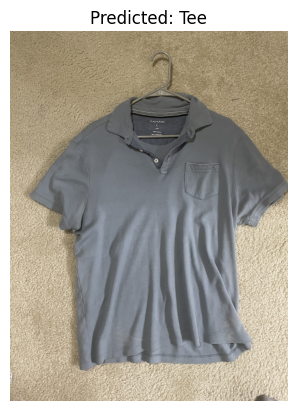

Predicted Class: Top for image: TestImages/IMG_2853.jpg


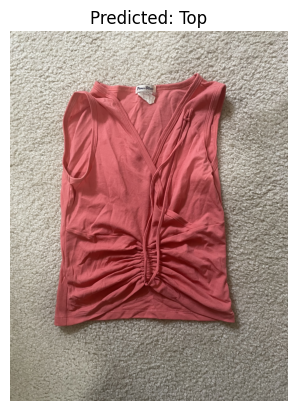

Predicted Class: Skirts for image: TestImages/IMG_2854.jpg


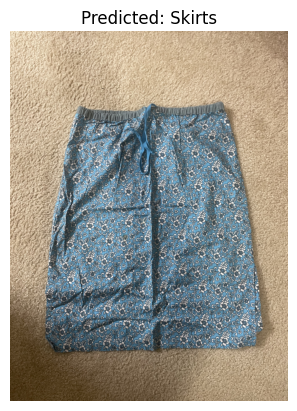

Predicted Class: Tee for image: TestImages/Jesus.png


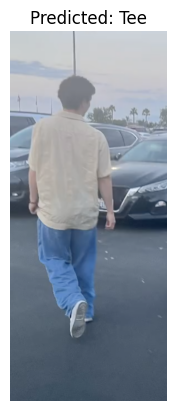

Predicted Class: Tee for image: TestImages/Jesus1.png


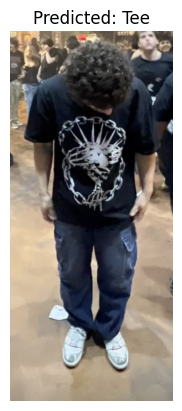

Predicted Class: Jeans for image: TestImages/Jeans.png


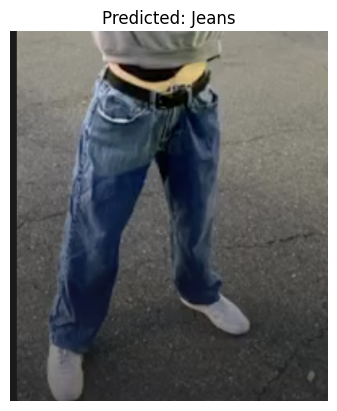

Predicted Class: Shorts for image: TestImages/Jeans2.png


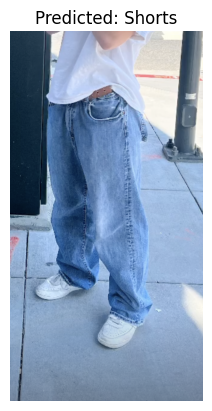

Predicted Class: Dress for image: TestImages/Dress.png


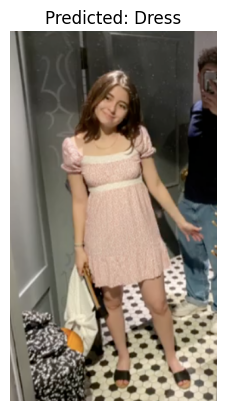

Predicted Class: Skirts for image: TestImages/Skirt1.png


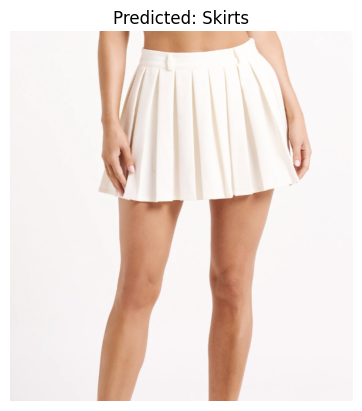

Predicted Class: Skirts for image: TestImages/Skirts2.png


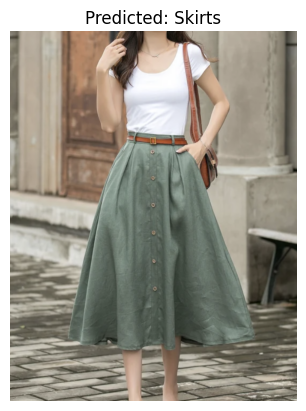

Predicted Class: Shorts for image: TestImages/Shorts1.png


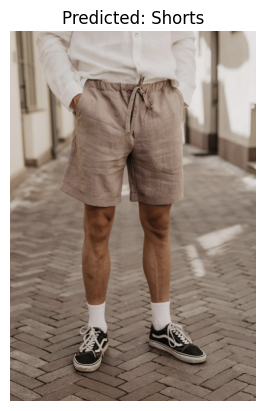

Predicted Class: Shorts for image: TestImages/Shorts2.png


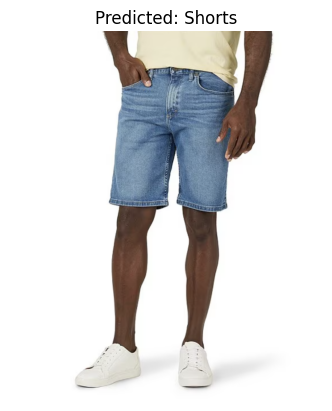

Predicted Class: Shorts for image: TestImages/Shorts3.png


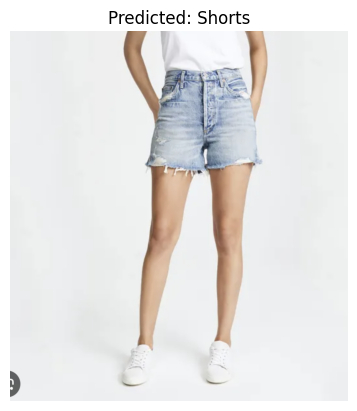

Predicted Class: Jacket for image: TestImages/Jacket1.png


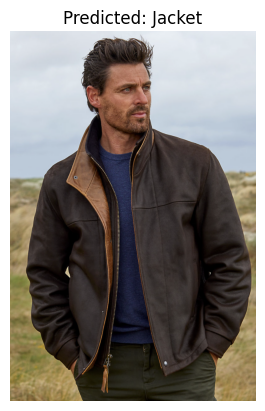

Predicted Class: Jacket for image: TestImages/Jacket2.png


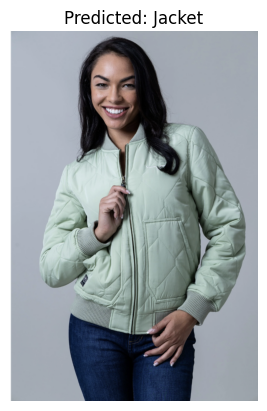

Predicted Class: Jacket for image: TestImages/Jacket3.png


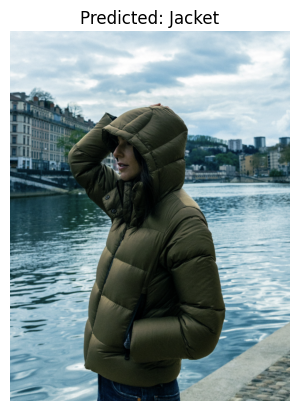

Predicted Class: Jacket for image: TestImages/Hoodie1.png


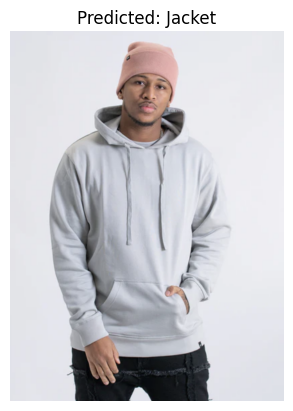

Predicted Class: Sweater for image: TestImages/Hoodie2.png


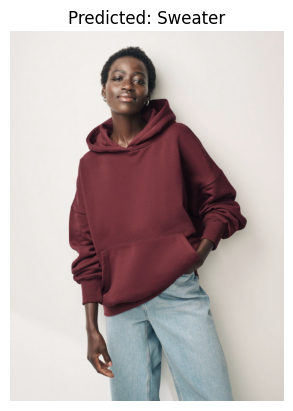

Predicted Class: Blouse for image: TestImages/Blouse1.png


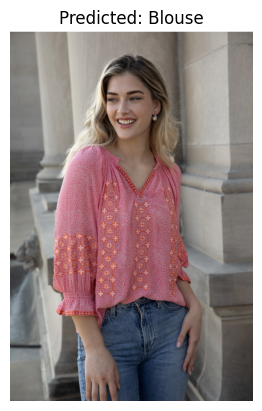

Predicted Class: Blouse for image: TestImages/Blouse2.png


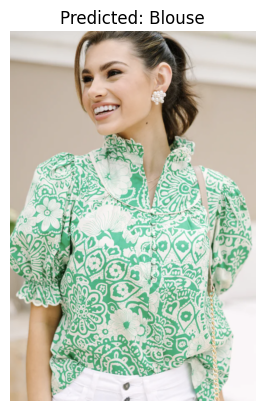

Predicted Class: Cardigan for image: TestImages/Cardigan1.png


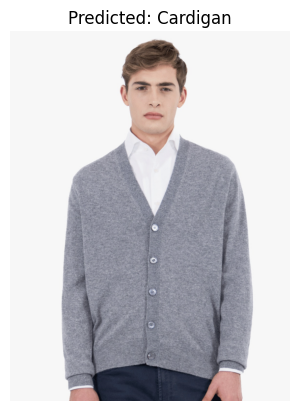

In [74]:
# Initialize the deterministic transform for inference
transform = CustomResNetTransform()

def run_inference_on_image(image_path):
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Image path '{image_path}' does not exist.")
        return

    # Load and process the image
    imageOriginal = Image.open(image_path).convert('RGB')
    image_transformed = transform(imageOriginal)
    img_tensor = image_transformed.unsqueeze(0).to(device)  # add batch dimension

    # Run inference
    with torch.no_grad():
        preds = model(img_tensor)
        predicted = torch.argmax(preds, dim=1).item()

    predicted_class = inference_label_mapping[predicted]
    print(f"Predicted Class: {predicted_class} for image: {image_path}")

    # Display the original image with predicted label
    plt.imshow(imageOriginal)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    IMAGE_PATHS = [
        "TestImages/IMG_2852.jpg",
        "TestImages/IMG_2853.jpg",
        "TestImages/IMG_2854.jpg",
        "TestImages/Jesus.png",
        "TestImages/Jesus1.png",
        "TestImages/Jeans.png",
        "TestImages/Jeans2.png",
        "TestImages/Dress.png",
        "TestImages/Skirt1.png",
        "TestImages/Skirts2.png",
        "TestImages/Shorts1.png",
        "TestImages/Shorts2.png",
        "TestImages/Shorts3.png",
        "TestImages/Jacket1.png",
        "TestImages/Jacket2.png",
        "TestImages/Jacket3.png",
        "TestImages/Hoodie1.png",
        "TestImages/Hoodie2.png",
        "TestImages/Blouse1.png",
        "TestImages/Blouse2.png",
        "TestImages/Cardigan1.png"
    ]
    
    for image_path in IMAGE_PATHS:
        run_inference_on_image(image_path)